## code to generate panels in Figure 4

Load libraries, functions and and dataset from pi_tailtrack experiment

In [1]:
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numba import njit, prange
from scipy import signal, interpolate
from tifffile import imsave

dir_path = sys.path[0]

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def GCaMPConvolve(trace, ker):
    if np.sum(trace) == 0:
        return trace
    else:
        trace_conv = np.convolve(trace, ker, 'full')
        trace_conv = trace_conv[1:trace.shape[0]+1] 
        trace_conv[np.logical_not(np.isfinite(trace_conv))] = 0
        trace_conv = trace_conv/max(trace_conv)
        return trace_conv

@njit
def pearsonr_vec_2Dnumb(x,y):
    # computes the pearson correlation coefficient between a a vector (x) and each row in 2d matrix (y), using numba acceleration
    
    n_rows_y = int(y.shape[0])
    corr = np.zeros((n_rows_y))
    for row_y in prange(n_rows_y):
        corr[row_y] = np.corrcoef(x, y[row_y,:])[0,1]
    return corr


#% load data from tail tracking

data_dir = os.path.join(dir_path, '20220822')

os.chdir(data_dir)
data = np.loadtxt(glob.glob('*coords.txt')[0], delimiter=',')
t_stamps = np.loadtxt(glob.glob('*tstamps.txt')[0], delimiter=',')

stim = t_stamps[1::2] # the stimluls recording pin record from pi_tailtrack
time = t_stamps[::2] # the timestamps from pi_tailtrack
x_coords = data[::2, :]
x_coords = x_coords - np.nanmean(x_coords[:,0], axis=0)
y_coords = data[1::2, :] 
y_coords = y_coords - np.nanmean(y_coords[:,0], axis=0)


n_frames = min((len(x_coords), len(y_coords)))
x_coords = x_coords[:n_frames]
y_coords = y_coords[:n_frames]


## Compute tail bending, plot some examples

c:\Users\owen.randlett\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
C:\Users\owen.randlett\AppData\Local\Temp/ipykernel_18444/249410736.py:4: RuntimeWarning: Mean of empty slice
  orients = np.nanmean(angles, axis=1)
C:\Users\owen.randlett\AppData\Local\Temp/ipykernel_18444/249410736.py:7: RuntimeWarning: Mean of empty slice
  bend_amps = np.nanmean(diff_angles, axis=1)


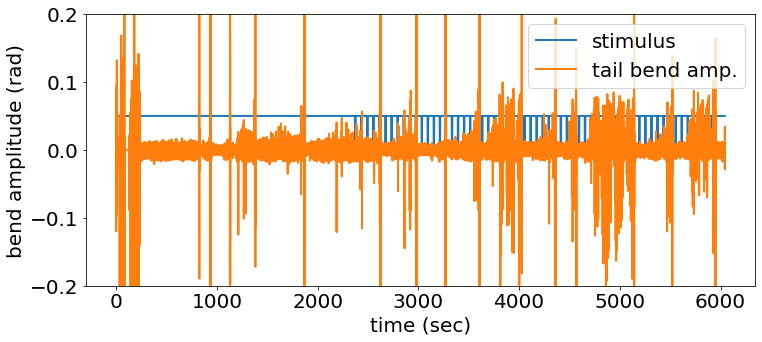

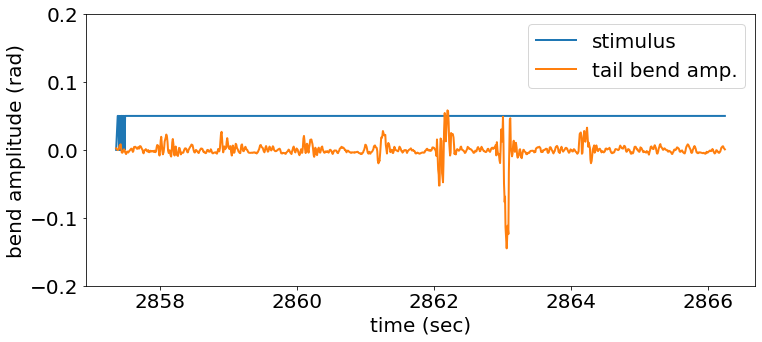

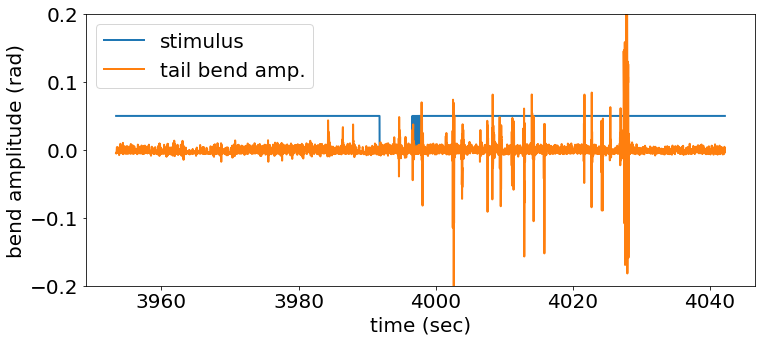

In [2]:
angles = np.arctan2(np.diff(y_coords, axis=1), np.diff(x_coords, axis=1))
angles = np.unwrap(angles)

orients = np.nanmean(angles, axis=1)
diff_angles = np.diff(angles, axis=1)

bend_amps = np.nanmean(diff_angles, axis=1)
bend_amps[np.isnan(bend_amps)] = 0
#bend_amps = bend_amps-np.mean(bend_amps)
bend_amps_filt = signal.savgol_filter(bend_amps, 11, 5)

# plot some traces of bend amplitude
x_ranges = [np.arange(len(stim)), np.arange(312000,313000), np.arange(435000,445000)]
for x_range in x_ranges:
    with plt.rc_context({'lines.linewidth': 2, 'figure.figsize': (12,5), 'font.size':20}):
        plt.plot(time[x_range], stim[x_range]*0.05, label='stimulus')
        plt.plot(time[x_range], bend_amps_filt[x_range], label="tail bend amp.")
        plt.ylim((-0.2,0.2))
        plt.ylabel('bend amplitude (rad)')
        plt.xlabel('time (sec)')
        plt.legend()
        plt.show()


## load Ca2+ imaging data

raw imaging data has been analyzed using suite2p

In [3]:
ops = np.load(os.path.join(data_dir, 'combined/ops.npy'), allow_pickle=True).item()
F = np.load(os.path.join(data_dir, 'combined/F.npy'), allow_pickle=True)
stat = np.load(os.path.join(data_dir, 'combined/stat.npy'), allow_pickle=True)
iscell = np.load(os.path.join(data_dir, 'combined/iscell.npy'), allow_pickle=True)

cell_thresh = 0.3 # classifier threshold for determining a "cell" ROI
cells = iscell[:,1] > cell_thresh
n_cells = np.sum(cells)

F_zscore = stats.zscore(F[cells,:], axis=1)
F_zscore[~np.isfinite(F_zscore)] = 0
stat_cells = stat[cells]

# we can use the motion artifacts in the Ca2+ imaging to see large motor events, when the brain jiggles. We can use this to sanity check that our traces from the pi_tailtrack are snychonized with the imaging correctly
motor_sig = ops['corrXY']
motor_sig[ops['badframes']] = 0
motor_pow = signal.savgol_filter(np.std(rolling_window(motor_sig, 3), -1), 15, 2)
motor_pow = motor_pow - np.median(motor_pow)
motor_pow = motor_pow/np.max(motor_pow)

# now we load the timestamps from the Ca2+ imaging
time_stamps_imaging = np.load(os.path.join(data_dir, 'time_stamps.npy'))
time_stamps_imaging = np.mean(time_stamps_imaging, axis=0)/1000 # time stamp in the middle of the repeated imaging stack, in msec

# find the indexes where the "dark flash" stimuli occur in the imaging session. 
stim_df = np.load(os.path.join(data_dir, 'stimvec_mean.npy'))
df_start_inds = np.where(np.diff(stim_df)>0.1)[0]
df_start_inds = np.delete(df_start_inds, np.where(np.diff(df_start_inds) == 1)[0]+1)

# get the timestamps of the first and less dark flash stimulus in the imaging data
tstamp_imaging_df = time_stamps_imaging[df_start_inds[0]]
tstamp_imaging_end = time_stamps_imaging[-1]
#%
# find the index there the first "dark flash" stimulus is seen in pi_tailtrack
df_start = np.where(np.diff(stim.flatten())==-1)[0][0]
t_df_start = time[df_start]

## Synchronize the timing 

determine the common timing for the GCaMP imaging experiment and the pi_tailtrack recording, plot examples of the GCaMP motion artifact vs pi_tailtrack analsis

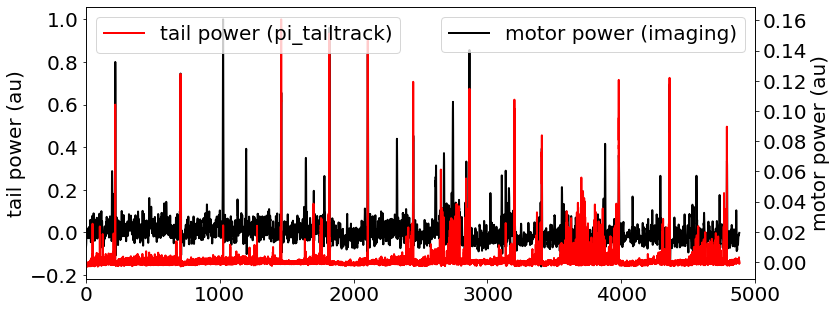

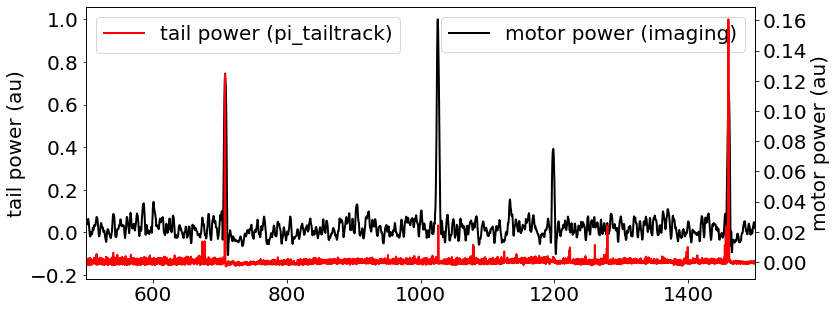

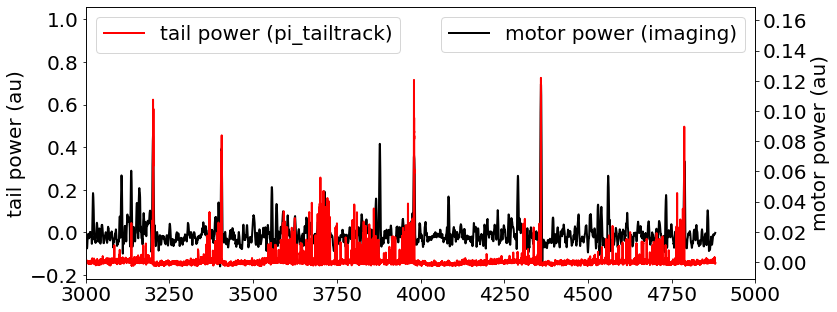

In [4]:

# determine where within the pi_tailtrack recording the imaging started and ended based on timestamps. Note this assumes that the pi_tailtrack recording starts before the imaging starts. 
t_imaging_start = t_df_start - tstamp_imaging_df
ind_imagin_start = np.where(time >= t_imaging_start)[0][0]
t_imaging_end = t_imaging_start + tstamp_imaging_end
ind_imaging_end = np.where(time >= t_imaging_end)[0][0]

#% simple analyses to identify bouts in the pi_tailtrack data and do some classification as either swims/struggles, and turning dirction
bend_amps_filt_imaging = bend_amps_filt[ind_imagin_start:ind_imaging_end]
time_duringimaging = time[ind_imagin_start:ind_imaging_end]
tail_power = np.std(rolling_window(bend_amps_filt_imaging, int(len(bend_amps_filt_imaging)/len(motor_pow))), -1)
tail_power = tail_power - np.median(tail_power)
bout_thresh = 0.003
bouts = tail_power > 0.003
bout_st_end = np.hstack([np.nan, np.diff(bouts.astype(int))])

time_duringimaging_st0 = time_duringimaging - time_duringimaging[0]
with plt.rc_context({'lines.linewidth': 2, 'figure.figsize': (12,5), 'font.size':20}):
    for xlims in [(0,5000), (500,1500), (3000,5000)]:
        fig, ax1 = plt.subplots()
        ax1.plot(time_stamps_imaging, motor_pow, 'k', label='motor power (imaging)')
        plt.legend(loc='upper right')
        
        ax2 = ax1.twinx()
        ax2.plot(time_duringimaging_st0, tail_power, 'r', label='tail power (pi_tailtrack)')
        plt.legend(loc='upper left')

        ax1.set_ylabel('tail power (au)')
        ax2.set_ylabel('motor power (au)')
        ax2.set_xlabel('time (sec)')
        plt.xlim(xlims)



## Identify and characterize individual bouts

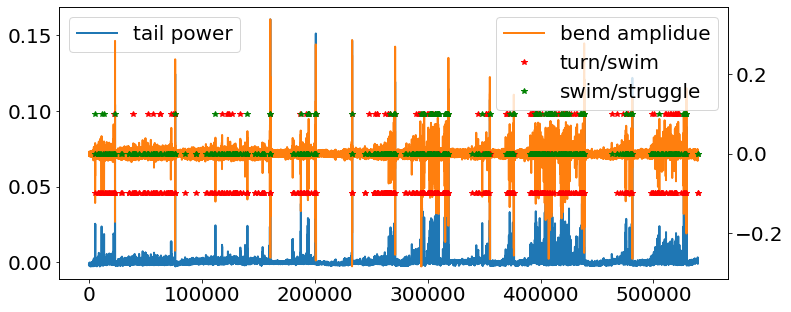

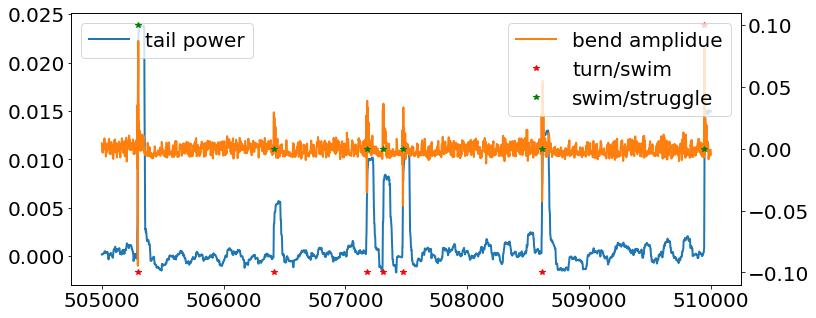

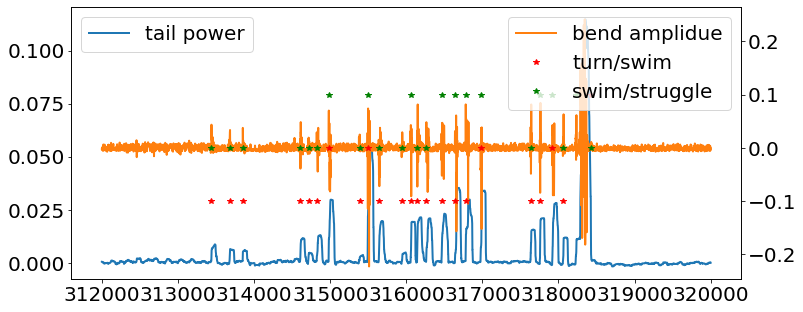

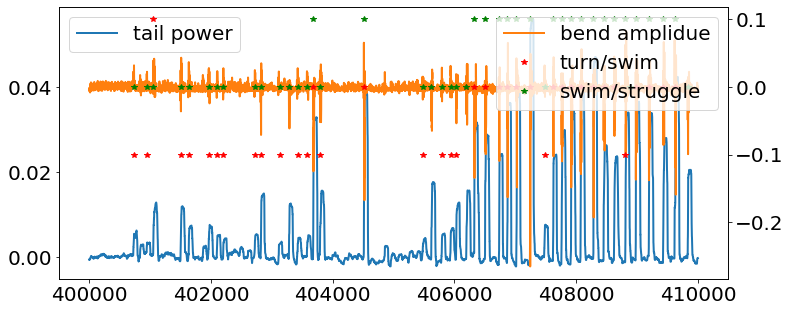

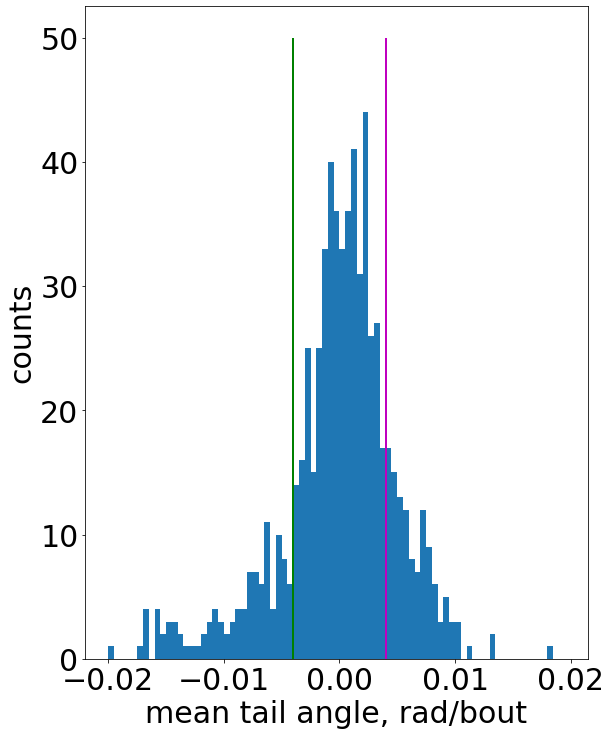

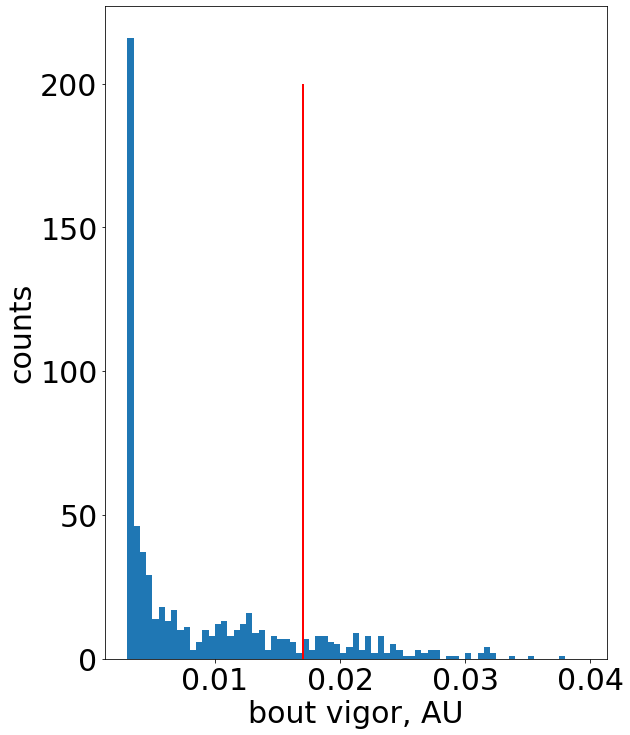

In [5]:
bout_st = np.where(bout_st_end == 1)[0]
bout_end = np.where(bout_st_end == -1)[0]
if len(bout_st) > len(bout_end):
    if bout_st[0] > bout_end[0]:
        bout_st = bout_st[1:]
    if  bout_st[-1] >  bout_end[-1]:
        bout_st = bout_st[:-1]

if len(bout_end) > len(bout_st):
    if bout_end[0] < bout_st[0]:
        bout_end = bout_end[1:]
    if bout_end[-1] < bout_st[-1]:
        bout_end = bout_end[:-1]
n_bouts = len(bout_st)
bouts_meanbend = np.zeros(n_bouts)
bouts_power = np.zeros(n_bouts)
for i in range(n_bouts):
    bouts_meanbend[i] = np.nanmean(bend_amps_filt_imaging[bout_st[i]:bout_end[i]]) 
    bouts_power[i] = np.nanmean(tail_power[bout_st[i]:bout_end[i]]) 

swim_turn_thresh = 0.004
swim_struggle_thresh = 0.017
#%


turn_swim = np.ones(bouts_meanbend.shape) # 1=swim,, 
turn_swim[bouts_meanbend<-swim_turn_thresh] = 2 # 2=turn left ...
turn_swim[bouts_meanbend>swim_turn_thresh] = 3 # 3=turn right (not 100% sure whice on right vs left)

swim_struggle = np.ones(bouts_meanbend.shape) # 1=swim,, 
swim_struggle[bouts_power > swim_struggle_thresh] = 2 # 2=struggle

turn_swim_vec = np.zeros(tail_power.shape)
turn_swim_vec[:] = np.nan

swim_struggle_vec = np.zeros(tail_power.shape)
swim_struggle_vec[:] = np.nan

for i in range(1,4):
    turn_swim_vec[bout_st[turn_swim == i]] = i
    swim_struggle_vec[bout_st[swim_struggle == i]] = i

x_ranges = [np.arange(len(tail_power)), np.arange(505000,510000), np.arange(312000,320000), np.arange(400000,410000)]
for x_range in x_ranges:
    with plt.rc_context({'lines.linewidth': 2, 'figure.figsize': (12,5), 'font.size':20}):
        fig, ax1 = plt.subplots()
        ax1.plot(x_range, tail_power[x_range], label='tail power')
    

        ax2 = ax1.twinx()
        ax2.plot(x_range, bend_amps_filt_imaging[x_range], 'C1', label='bend amplidue')
        ax2.plot(x_range, (turn_swim_vec[x_range]-2) * 0.1, 'r*', label='turn/swim')
        ax2.plot(x_range, (swim_struggle_vec[x_range]-1) * 0.1, 'g*', label='swim/struggle')
        #plt.ylim((-0.2,0.2))
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()
#%

out_dir = os.path.join(data_dir, 'images_out')
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
os.chdir(out_dir)
with plt.rc_context({'lines.linewidth': 2, 'figure.figsize': (9,12), 'font.size':30}):
    plt.hist(bouts_meanbend, np.arange(-0.02, 0.02, 0.0005))
    plt.vlines([-swim_turn_thresh, swim_turn_thresh], ymin=0, ymax=50, colors=['g', 'm'])
    plt.xlabel('mean tail angle, rad/bout')
    plt.ylabel('counts')
    plt.savefig('tailangle.svg')
    plt.show()

    plt.hist(bouts_power,  np.arange(0.003, 0.04, 0.0005))
    plt.vlines(swim_struggle_thresh,  ymin=0, ymax=200, colors='r')
    plt.xlabel('bout vigor, AU')
    plt.ylabel('counts')
    plt.savefig('tailpower.svg')
    plt.show()

## Correlate regressors for the bout parameters from pi_tailtrack with the fluorescence traces in individual ROIs from Ca2+ imaging

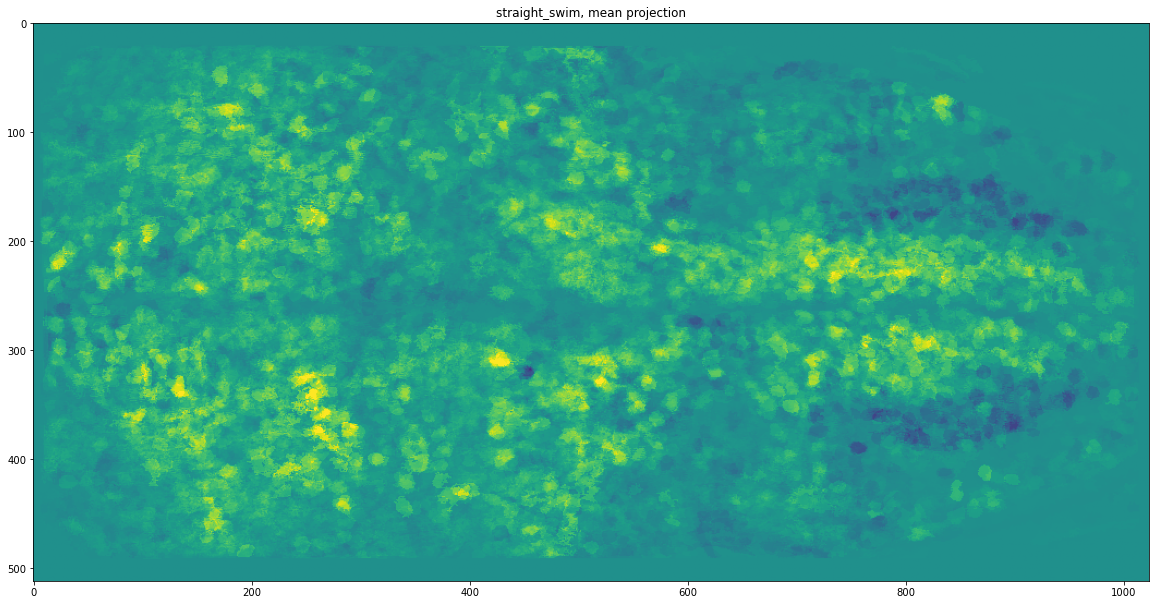

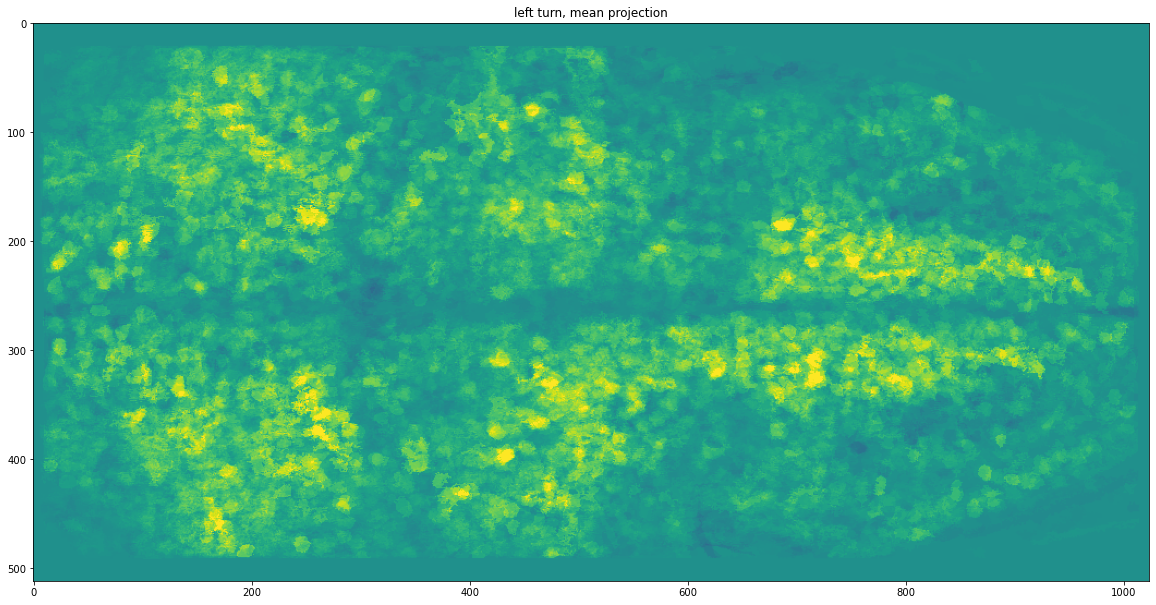

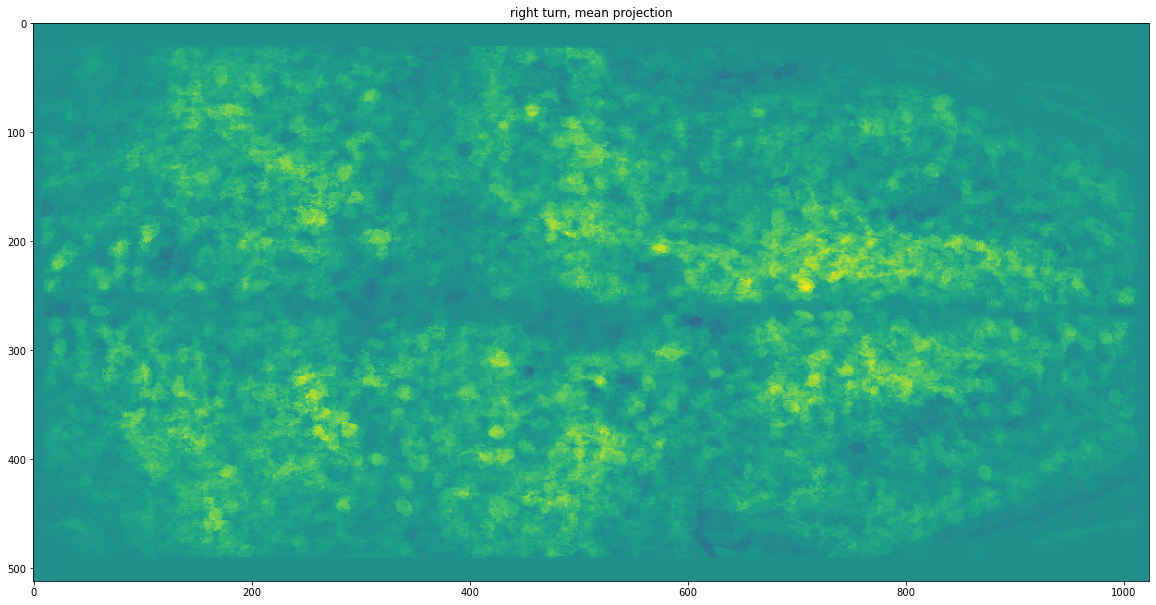

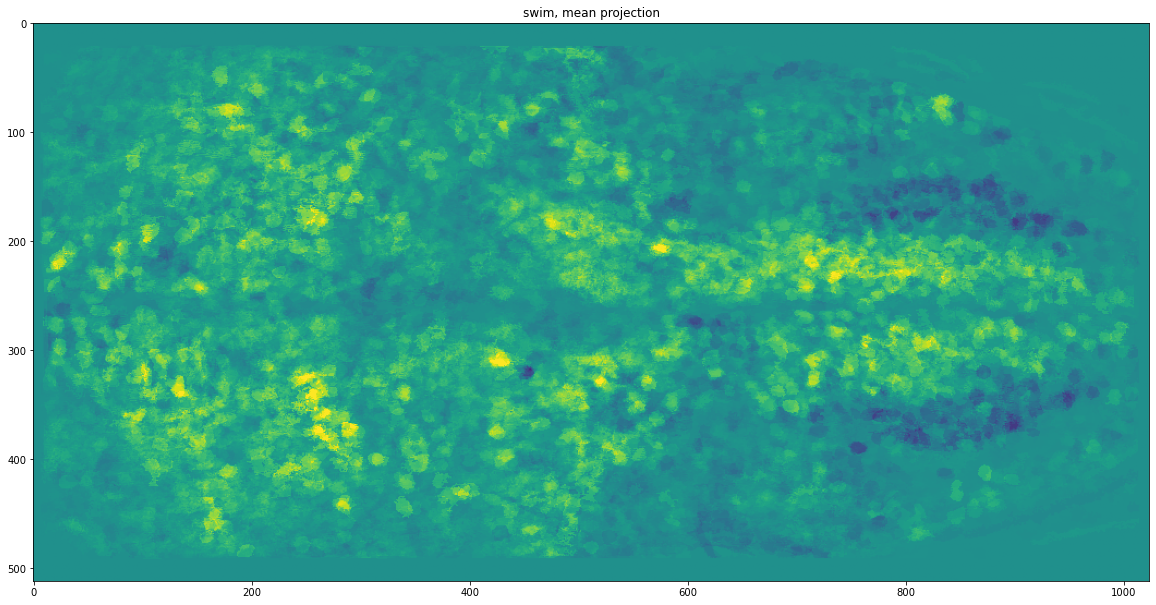

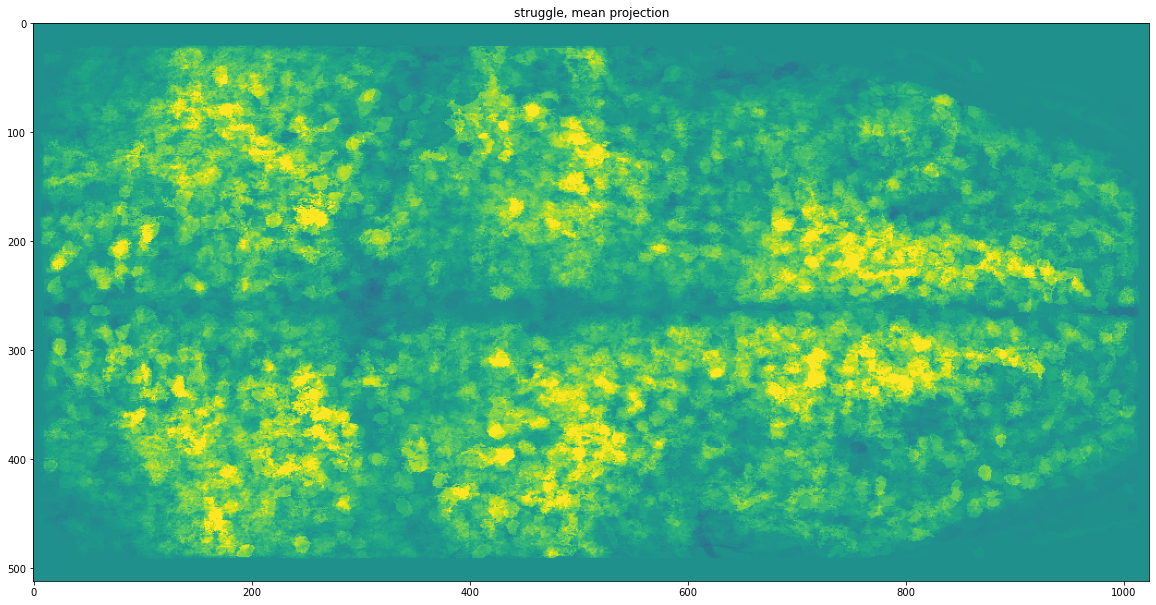

In [9]:
#% identify the relevant imaging frames for the bout starts ends that were found based on pi_tailtrack

bout_st_timestamp = time_duringimaging_st0[bout_st]
bout_end_timestamp = time_duringimaging_st0[bout_end]

bout_starts_frames = np.zeros(n_bouts, dtype=int)
bout_ends_frames = np.zeros(n_bouts, dtype=int)
for ind in range(n_bouts):
    bout_starts_frames[ind] = np.where(time_stamps_imaging <= bout_st_timestamp[ind])[0][-1]
    bout_ends_frames[ind] = np.where(time_stamps_imaging >= bout_end_timestamp[ind])[0][0]

bout_ends_frames[bout_starts_frames==bout_ends_frames]+=1

swim_turn_vec_frames = np.zeros((3, len(motor_pow)))
for i in range(len(turn_swim)):
    st = bout_starts_frames[i]
    end = bout_ends_frames[i]
    swim_turn_vec_frames[int(turn_swim[i]-1), st:end] = 1

swim_struggle_vec_frames = np.zeros((2, len(motor_pow)))
for i in range(len(swim_struggle)):
    st = bout_starts_frames[i]
    end = bout_ends_frames[i]
    swim_struggle_vec_frames[int(swim_struggle[i]-1), st:end] = 1


# parameters for GCaMP kernel
DecCnst = 0.3
RiseCnst = 0.5
frame_rate = 1.976
DecCnst = DecCnst*frame_rate # now in frames
RiseCnst = RiseCnst*frame_rate

KerRise = np.power(2, (np.arange(0,5)*RiseCnst)) - 1
KerRise= KerRise[KerRise < 1]
KerRise = KerRise/max(KerRise)

KerDec = np.power(2, (np.arange(20, 0, -1)*DecCnst))
KerDec = (KerDec - min(KerDec))/(max(KerDec) - min(KerDec));

KerDec = KerDec[KerDec > 0]
KerDec = KerDec[1:]
KerTotal = np.concatenate([KerRise, KerDec])


# make regressors with gcamp kernel

regressor_straightswim = GCaMPConvolve(swim_turn_vec_frames[0,:], KerTotal)
regressor_left = GCaMPConvolve(swim_turn_vec_frames[1,:], KerTotal)
regressor_right = GCaMPConvolve(swim_turn_vec_frames[2,:], KerTotal)
regressor_swim = GCaMPConvolve(swim_struggle_vec_frames[0,:], KerTotal)
regressor_struggle = GCaMPConvolve(swim_struggle_vec_frames[1,:], KerTotal)

corrMat= np.zeros([n_cells, 5])
corr_order = [
    'straight_swim',
    'left turn',
    'right turn',
    'swim',
    'struggle'
]
corrMat[:, 0] =  pearsonr_vec_2Dnumb(regressor_straightswim, F_zscore)
corrMat[:, 1] =  pearsonr_vec_2Dnumb(regressor_left, F_zscore)
corrMat[:, 2] =  pearsonr_vec_2Dnumb(regressor_right, F_zscore)
corrMat[:, 3] =  pearsonr_vec_2Dnumb(regressor_swim, F_zscore)
corrMat[:, 4] =  pearsonr_vec_2Dnumb(regressor_struggle, F_zscore)
corrMat[np.isnan(corrMat)] = 0

# Reconstruct images based on the correlation values


height, width = ops['meanImg'].shape

im_stack = np.zeros((len(corr_order), height, width))
for corr in range(5):
    

    for i in range(n_cells):
        ypix = stat_cells[i]['ypix']
        xpix = stat_cells[i]['xpix']
        im_stack[corr, ypix, xpix] = corrMat[i, corr]
    
    # plt.figure(figsize=(20,20))
    # plt.imshow(im_stack[corr, :,:], vmin=-0.3, vmax=0.3)
    # plt.title(corr_order[corr])
    # plt.show()

imsave('corr_stacks.tif', im_stack)
imsave('anat_image.tif', ops['meanImg'])
#%

# reconstruct the original stack, plot Z-projections
n_col = 3
n_row = 4
n_sl = int(n_col*n_row)
height_sl = int(height/n_row)
width_sl = int(width/n_col)
def reslie_stack(stack):
    k = 0
    stack_reslice = np.zeros((n_sl, height_sl, width_sl))
    for i in range(n_row):
         row_slice = stack[height_sl*i:height_sl*(i+1), :]
         for j in range(n_col):
            stack_reslice[k,:,:] = row_slice[:, width_sl*j:width_sl*(j+1)]
            k+=1
    return stack_reslice

for corr in range(5):
    stack_reslice = reslie_stack(im_stack[corr,:,:])
    plt.figure(figsize=(20,20))
    plt.imshow(np.mean(stack_reslice, axis=0), vmin=-0.1, vmax=0.1)
    plt.title(corr_order[corr] + ', mean projection')
    plt.show()

    imsave('corr_stacks_slices' + corr_order[corr] + '.tif', stack_reslice)

stack_reslice = reslie_stack(ops['meanImg'])
imsave('anatomy_stack.tif', stack_reslice)
